<a href="https://colab.research.google.com/github/gajanm/AdminDashBoard/blob/main/FederatedLearningSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/research/"

In [3]:
%cd /content/drive/MyDrive/research/

/content/drive/MyDrive/research


In [4]:
import json
from keras.models import load_model


In [5]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import csv
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns


In [7]:
df = pd.read_csv("Combined.csv")

In [9]:
df

,Unnamed: 0.1,Unnamed: 0,filepaths,labels,dataset,exists
0,0,0,/content/drive/MyDrive/research/APTOS/Mild/28f...,Mild,APTOS,True
1,1,1,/content/drive/MyDrive/research/APTOS/Mild/a3d...,Mild,APTOS,True
2,2,2,/content/drive/MyDrive/research/APTOS/Mild/068...,Mild,APTOS,True
3,3,3,/content/drive/MyDrive/research/APTOS/Mild/c96...,Mild,APTOS,True
4,4,4,/content/drive/MyDrive/research/APTOS/Mild/c1e...,Mild,APTOS,True
...,...,...,...,...,...,...
62495,24995,24995,./EYEPACSaug/Proliferate_DR/aug-_297_578619.jpg,Proliferate_DR,EYEPACS,False
62496,24996,24996,./EYEPACSaug/Proliferate_DR/aug-_298_276064.jpg,Proliferate_DR,EYEPACS,False
62497,24997,24997,./EYEPACSaug/Proliferate_DR/aug-_299_8721567.jpg,Proliferate_DR,EYEPACS,False
62498,24998,24998,./EYEPACSaug/Proliferate_DR/aug-_300_6409360.jpg,Proliferate_DR,EYEPACS,False


<Axes: >

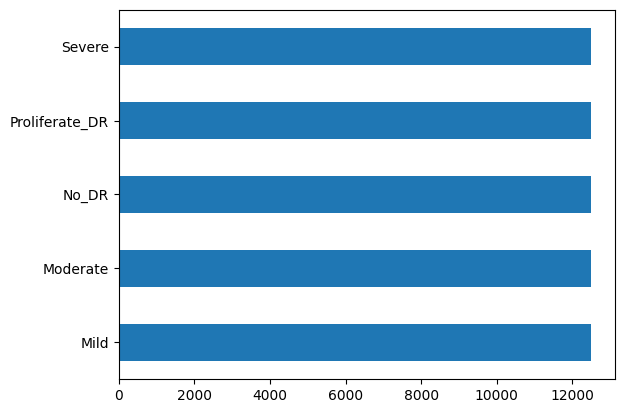

In [10]:
df['labels'].value_counts().plot(kind='barh')

In [11]:
aptos = df[df['dataset'] == 'APTOS']
ddr = df[df['dataset'] == 'DDR']
eyepacs = df[df['dataset'] == 'EYEPACS']

<Axes: >

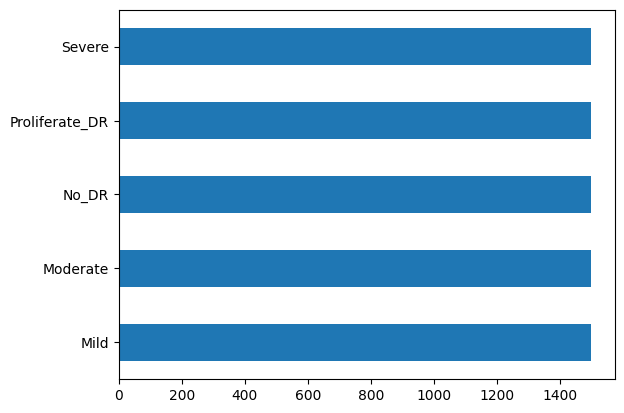

In [13]:
aptos['labels'].value_counts().plot(kind='barh')

<Axes: >

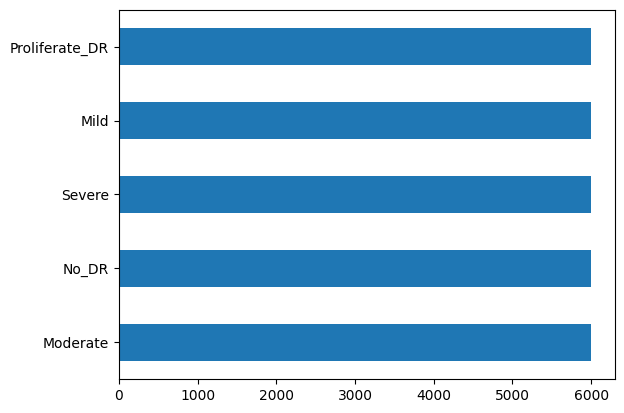

In [14]:
ddr['labels'].value_counts().plot(kind='barh')

<Axes: >

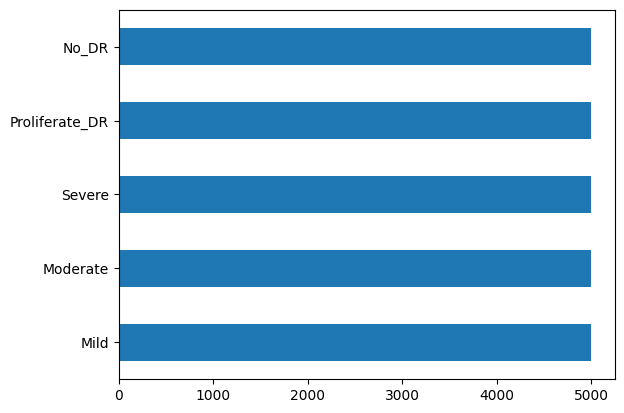

In [15]:
eyepacs['labels'].value_counts().plot(kind='barh')

In [18]:
import cv2
from PIL import Image
import random

In [ ]:
#Lowering Image Quality for APTOS
output_dir = "lower_quality_aptos"
os.makedirs(output_dir, exist_ok=True)

for index, row in aptos.iterrows():
    filepath = row['filepaths']
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pil_img = Image.fromarray(img)
    random_quality = random.randint(10, 15)
    pil_img.save("new_image.jpg", quality=random_quality)

    new_img = cv2.imread("new_image.jpg")
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

    output_filename = os.path.basename(filepath)
    output_path = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_path, new_img)


In [25]:
h1 = ddr
h2 = eyepacs
h3 = aptos

clients = {
    'client1': h1,
    'client2': h2,
    'client3': h3
}


In [24]:
def create_keras_model():
  model='EfficientNetB0'
  model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
  x=base_model.output
  x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),

                  bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x=Dropout(rate=.45, seed=123)(x)
  output=Dense(5, activation='softmax')(x)
  model=Model(inputs=base_model.input, outputs=output)
  model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
  return model

In [ ]:
import tensorflow_federated as tff

In [ ]:
def model_fn():
  model = create_keras_model()
  return tff.learning.models.from_keras_model(
      model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    create_keras_model(),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))


In [ ]:
num_rounds = 50
patience = 5
best_loss = float('inf')
rounds_without_improvement = 0

for round in range(num_rounds):

  sample_clients = list(clients.keys())  # ['client1', 'client2', 'client3']

  # Create federated data based on selected clients
  federated_train_data = [clients[client] for client in sample_clients]

  state, metrics = training_process.next(state, federated_train_data)
  print('Round:', round, metrics)
  current_loss = metrics['loss']

  if current_loss < best_loss:
    best_loss = current_loss
    rounds_without_improvement = 0
  else:
    rounds_without_improvement += 1

  if rounds_without_improvement >= patience:
      print("Early stopping: Loss hasn't improved for {} rounds.".format(patience))
      break

  print('Round:', round, metrics)

In [ ]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=3000
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img



test batch size:  75   test steps:  40


In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.5, patience=8): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        self.no_improvement_count=0
        self.patience=patience

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        self.model.save('DDREfficientNet.h5')
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')

        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.no_improvement_count = 0  # Reset the counter since there is an improvement



            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground

            self.no_improvement_count += 1  # Increment the counter since there is no improvement

            if self.no_improvement_count >= self.patience:
                msg = f'\nValidation loss has not improved for {self.patience} consecutive epochs. Stopping training.'
                print_in_color(msg, (255, 0, 0))  # Red foreground
                self.model.save('DDREfficientNet.h5')
                self.model.stop_training = True  # Halt training


            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        """
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground
            """



In [ ]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [ ]:
model_name='EfficientNetB0'
base_model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
efficientnetb0=Model(inputs=base_model.input, outputs=output)



efficientnetb0.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1

In [ ]:

def get_model_size(model):
    model_size = sum(np.product(w.shape) for w in model.trainable_variables)
    model_size += sum(np.product(w.shape) for w in model.non_trainable_variables)
    return model_size

model_name='MobileNetV2'
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
mobilenetv2=Model(inputs=base_model.input, outputs=output)
mobilenetv2.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', , 'AUC'])
model_size = get_model_size(mobilenetv2)
print(f"Estimated model size: {model_size} parameters")

Estimated model size: 2592325 parameters


In [ ]:
train_df

,filepaths,labels
28,/content/drive/MyDrive/research/gaussian_filte...,Severe
799,/content/drive/MyDrive/research/gaussian_filte...,No_DR
4495,./aug/Severe/aug-_173_8776189.jpg,Severe
658,/content/drive/MyDrive/research/gaussian_filte...,No_DR
1035,/content/drive/MyDrive/research/gaussian_filte...,No_DR
...,...,...
5218,./aug/Proliferate_DR/aug-_259_4781121.jpg,Proliferate_DR
4060,./aug/Severe/aug-_124_131609.jpg,Severe
1346,/content/drive/MyDrive/research/gaussian_filte...,No_DR
3454,./aug/Severe/aug-_97_1346838.jpg,Severe


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/research/APTOS_Train.csv")

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'ndf' is your dataset
# Set random_state for reproducibility
train_df, val_df = train_test_split(df, test_size=0.2, random_state=123)
#valid_df, test_df = train_test_split(ndf, test_size=0.5, random_state=123)

# Check the shapes of the resulting splits
print("Train set shape:", train_df['labels'].value_counts())
print("Validation set shape:", valid_df['labels'].value_counts())
#print("Test set shape:", test_df['labels'].value_counts())

Train set shape: Mild              1229
No_DR             1209
Proliferate_DR    1194
Severe            1185
Moderate          1183
Name: labels, dtype: int64


NameError: name 'valid_df' is not defined

In [ ]:
train_df

,Unnamed: 0.1,Unnamed: 0,filepaths,labels,dataset,exists
0,2423,2423,/content/drive/MyDrive/research/APTOS/No_DR/17...,No_DR,APTOS,True
1,5681,5681,/content/drive/MyDrive/research/aug/Proliferat...,Proliferate_DR,APTOS,True
2,2868,2868,/content/drive/MyDrive/research/APTOS/No_DR/b0...,No_DR,APTOS,True
3,426,426,/content/drive/MyDrive/research/APTOS/Moderate...,Moderate,APTOS,True
4,7075,7075,/content/drive/MyDrive/research/aug/Severe/aug...,Severe,APTOS,True
...,...,...,...,...,...,...
6745,5218,5218,/content/drive/MyDrive/research/aug/Proliferat...,Proliferate_DR,APTOS,True
6746,4060,4060,/content/drive/MyDrive/research/aug/Mild/aug-_...,Mild,APTOS,True
6747,1346,1346,/content/drive/MyDrive/research/APTOS/Moderate...,Moderate,APTOS,True
6748,3454,3454,/content/drive/MyDrive/research/aug/Mild/aug-_...,Mild,APTOS,True


In [ ]:
#Before adressing class imbalance

from sklearn.model_selection import StratifiedKFold
import numpy as np
epochs=40

train_df, test_df = train_test_split(ndf, test_size=0.1, random_state=123)


# Check the shapes of the resulting splits
print("Train set shape:", train_df['labels'].value_counts())
print("Test set shape:", test_df['labels'].value_counts())


Train set shape: Mild              1358
Proliferate_DR    1357
No_DR             1354
Severe            1349
Moderate          1332
Name: labels, dtype: int64
Test set shape: Moderate          168
Severe            151
No_DR             146
Proliferate_DR    143
Mild              142
Name: labels, dtype: int64


In [ ]:
train_df

,Unnamed: 0.1,Unnamed: 0,filepaths,labels,dataset,exists
20679,13179,13179,./DDRaug/Moderate/aug-_923_5180059.jpg,Moderate,DDR,False
698,698,698,/content/drive/MyDrive/research/APTOS/Moderate...,Moderate,APTOS,True
54058,16558,16558,./EYEPACSaug/Severe/aug-_372_6583921.jpg,Severe,EYEPACS,False
15439,7939,7939,/content/drive/MyDrive/research/DDR/No_DR/007-...,No_DR,DDR,True
60005,22505,22505,./EYEPACSaug/Proliferate_DR/aug-_417_4875582.jpg,Proliferate_DR,EYEPACS,False
...,...,...,...,...,...,...
61404,23904,23904,./EYEPACSaug/Proliferate_DR/aug-_250_7214646.jpg,Proliferate_DR,EYEPACS,False
17730,10230,10230,/content/drive/MyDrive/research/DDR/No_DR/2017...,No_DR,DDR,True
28030,20530,20530,./DDRaug/Mild/aug-_357_4469428.jpg,Mild,DDR,False
15725,8225,8225,/content/drive/MyDrive/research/DDR/No_DR/2017...,No_DR,DDR,True


In [ ]:
epochs = 40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 8 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=50 # number of epochs to run before asking if you want to halt training




# ... (your existing code)
trgen=ImageDataGenerator(preprocessing_function=scalar,
                         horizontal_flip=True,
                         rotation_range=30,
                         brightness_range = [0.8, 1.2]
                         )
tvgen=ImageDataGenerator(preprocessing_function=scalar)

# Assuming you have the data in X and y, where X is your features and y is your labels
X = train_df['filepaths']  # Replace with your actual feature data
y = train_df['labels']  # Replace with your actual labels

# Iterate through each fold

# Create data generators for the current fold
train_gen = trgen.flow_from_dataframe(
      train_df,
      x_col='filepaths',
      y_col='labels',
      target_size=img_size,
      class_mode='categorical',
      color_mode='rgb',
      shuffle=True,
      batch_size=batch_size
)

train_steps=int(len(train_gen.labels)/batch_size)
batches=train_steps

valid_gen = tvgen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

    # ... (your existing code, create model, compile, and define callbacks)
model_name='EfficientNetB0'
base_model=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                        bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
efficientnetb0=Model(inputs=base_model.input, outputs=output)
efficientnetb0.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks=[LR_ASK(model=efficientnetb0,
                       epochs=epochs,  ask_epoch=40)]

    # Fit the model for the current fold and store the history
history = efficientnetb0.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
            validation_steps=None,  shuffle=False,  initial_epoch=0)







Found 24000 validated image filenames belonging to 5 classes.
Found 3000 validated image filenames belonging to 5 classes.
16705208/16705208 [==============================] - 1s 0us/step
ask_epoch >= epochs, will train for  40  epochs
Training will proceed until epoch 50 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
600/600 [==============================] - ETA: 0s - loss: 4.9697 - accuracy: 0.6625 - auc: 0.8919 - precision: 0.7154 - recall: 0.5715 
 validation loss of  2.7550 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

600/600 [==============================] - 12372s 21s/step - loss: 4.9697 - accuracy: 0.6625 - auc: 0.8919 - precision: 0.7154 - recall: 0.5715 - val_loss: 2.7550 - val_accuracy: 0.7553 - val_auc: 0.9377 - val_precision: 0.7868 - val_recall: 0.7060
Epoch 2/40
600/600 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


learning rate was automatically adjusted from 0.000002 to 0.000001, model weights set to best weights

600/600 [==============================] - 352s 586ms/step - loss: 0.2728 - accuracy: 0.9505 - auc: 0.9964 - precision: 0.9597 - recall: 0.9376 - val_loss: 0.4251 - val_accuracy: 0.9000 - val_auc: 0.9864 - val_precision: 0.9044 - val_recall: 0.8920
loading model with weights from epoch 13

training elapsed time was 5.0 hours, 19.0 minutes, 34.64 seconds)



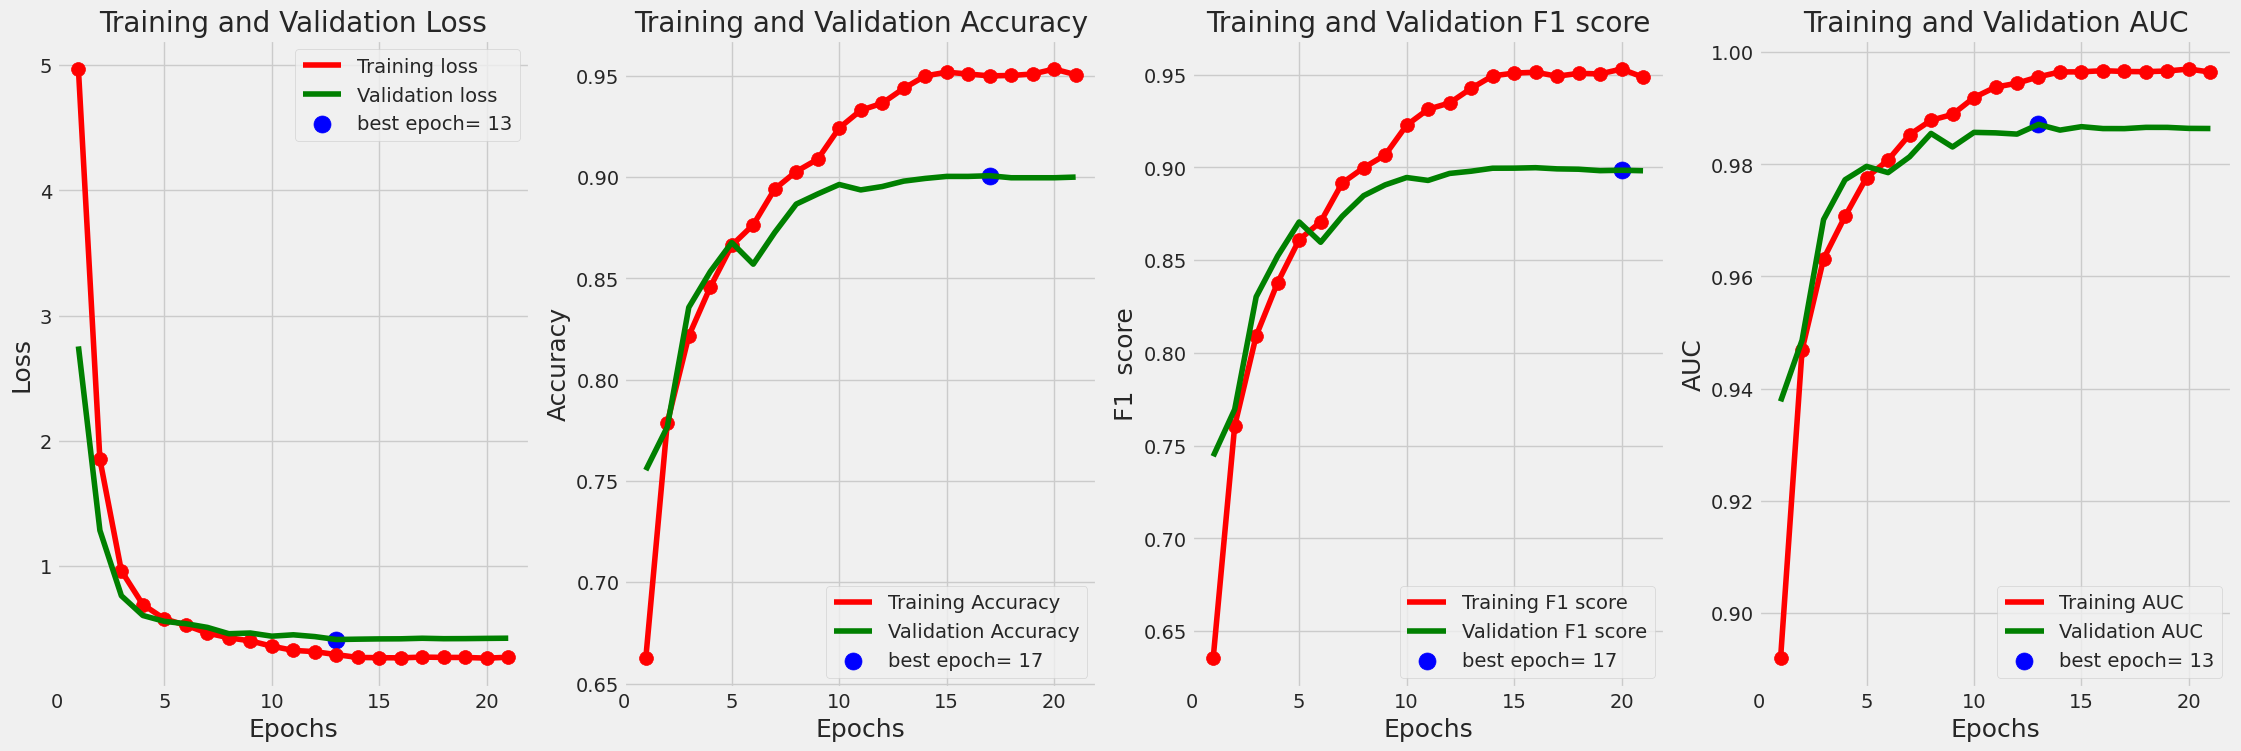

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tprec= tr_data.history['precision']
    vprec=tr_data.history['val_precision']
    trecall= tr_data.history['recall']
    vrecall= tr_data.history['val_recall']
    #tf1=tr_data.history['F1_score']
    #vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    tf1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(tprec, trecall)]
    vf1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(vprec, vrecall)]

    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=19#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]

    index_vf1=19# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()

    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=auc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/research/DDR_Test.csv")

In [ ]:
test_df

,Unnamed: 0.1,Unnamed: 0,filepaths,labels,dataset,exists
0,25665,25665,/content/drive/MyDrive/research/DDRaug/Prolife...,Proliferate_DR,DDR,True
1,16464,16464,/content/drive/MyDrive/research/DDRaug/Severe/...,Severe,DDR,True
2,22386,22386,/content/drive/MyDrive/research/DDRaug/Mild/au...,Mild,DDR,True
3,10149,10149,/content/drive/MyDrive/research/DDR/No_DR/2017...,No_DR,DDR,True
4,8729,8729,/content/drive/MyDrive/research/DDR/No_DR/007-...,No_DR,DDR,True
...,...,...,...,...,...,...
2995,8501,8501,/content/drive/MyDrive/research/DDR/No_DR/2017...,No_DR,DDR,True
2996,12510,12510,/content/drive/MyDrive/research/DDRaug/Moderat...,Moderate,DDR,True
2997,11625,11625,/content/drive/MyDrive/research/DDR/Proliferat...,Proliferate_DR,DDR,True
2998,18168,18168,/content/drive/MyDrive/research/DDRaug/Severe/...,Severe,DDR,True


In [ ]:
tsgen = ImageDataGenerator(preprocessing_function=scalar)

test_gen = tsgen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

print(test_gen)





Found 3000 validated image filenames belonging to 5 classes.


In [ ]:
efficientnetb0 = load_model('/content/drive/MyDrive/research/EYEPACSEfficientnet.h5')



In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions


In [ ]:
img_path = "/content/drive/MyDrive/research/gaussian_filtered_images/No_DR/0182152c50de.png"  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = efficientnetb0.predict(img_array).tolist()
print(predictions)
predicted_class_index = np.argmax(predictions[0])
print("Predicted Class Index:", predicted_class_index)


1/1 [==============================] - 0s 27ms/step
[[0.0031706492882221937, 0.002272174460813403, 0.9920235872268677, 0.001448769005946815, 0.0010847896337509155]]
Predicted Class Index: 2


In [ ]:
predictions = efficientnetb0.predict(img_array)

# Interpret the results (print or process accordingly)
print(predictions)

1/1 [==============================] - 0s 24ms/step
[[0.00572905 0.04383907 0.00482913 0.01443984 0.9311629 ]]


In [ ]:
print(predictions.shape)

predicted_class_index = np.argmax(predictions[0])
print("Predicted Class Index:", predicted_class_index)

(1, 5)
0.005729052
Predicted Class Index: 4


In [ ]:
test = efficientnetb0.predict(test_gen)




75/75 [==============================] - 1316s 18s/step


In [ ]:
true_labels = test_gen.classes  # Get labels from the generator
n_classes = len(np.unique(true_labels))

In [ ]:
from keras.utils import to_categorical
true_labels = to_categorical(true_labels, num_classes=n_classes)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
for i in range(n_classes):
   print(f'ROC AUC for class {i}: {roc_auc[i]}')

ROC AUC for class 0: 0.984198283692007
ROC AUC for class 1: 0.9577767523194248
ROC AUC for class 2: 0.990290811492665
ROC AUC for class 3: 0.9984323869004902
ROC AUC for class 4: 0.9965813233671149


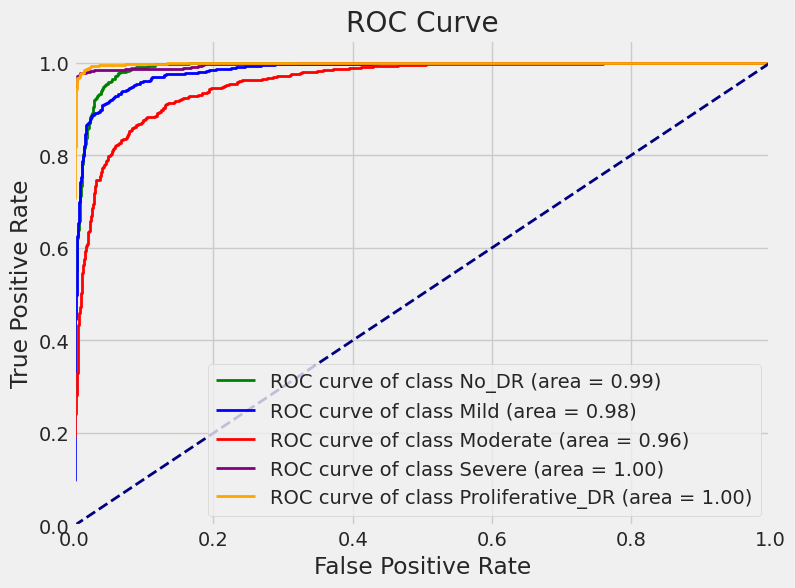

In [ ]:
class_labels = ['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']
colors = ['blue', 'red', 'green', 'orange', 'purple']

plt.figure(figsize=(8, 6))

# Define the custom plotting order
plot_order = [2, 0, 1, 4, 3]

for i in plot_order:
    label = class_labels[i]
    color = colors[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classes = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
num_classes = len(classes)

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

In [ ]:
confusion_matrix[0, 0] = 1185
confusion_matrix[0, 1] = 9
confusion_matrix[0, 2] = 22
confusion_matrix[0, 3] = 0
confusion_matrix[0, 4] = 0

confusion_matrix[1, 0] = 128
confusion_matrix[1, 1] = 1083
confusion_matrix[1, 2] = 22
confusion_matrix[1, 3] = 2
confusion_matrix[1, 4] = 0

confusion_matrix[2, 0] = 3
confusion_matrix[2, 1] = 99
confusion_matrix[2, 2] = 1098
confusion_matrix[2, 3] = 37
confusion_matrix[2, 4] = 10

confusion_matrix[3, 0] = 8
confusion_matrix[3, 1] = 5
confusion_matrix[3, 2] = 36
confusion_matrix[3, 3] = 1228
confusion_matrix[3, 4] = 2

confusion_matrix[4, 0] = 5
confusion_matrix[4, 1] = 6
confusion_matrix[4, 2] = 21
confusion_matrix[4, 3] = 10
confusion_matrix[4, 4] = 1231

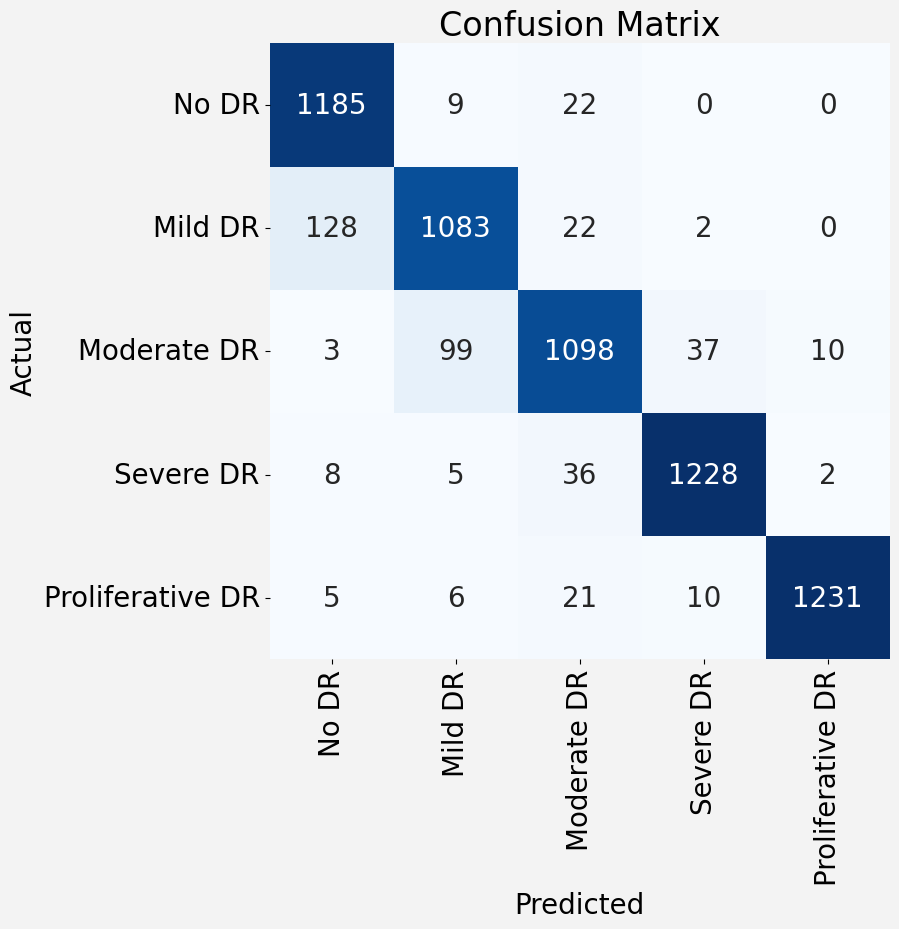

'\nelse:\n            fig_width= int(5 * .5)\n            fig_height= int(5 * .5)\n        plt.figure(figsize=(fig_width, fig_height))\n        sns.heatmap(reordered_cm, annot=True, vmin=0, fmt=\'g\', cmap=\'Blues\', cbar=False)\n        #plt.xticks(np.arange(length)+.5, classes, rotation= 90)\n        #plt.yticks(np.arange(length)+.5, classes, rotation=0)\n        plt.xticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=90)\n        plt.yticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=0)\n        plt.xlabel("Predicted")\n        plt.ylabel("Actual")\n        plt.title("Confusion Matrix")\n        plt.show()\n  '

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots(figsize=(8,8))  # Create figure and axes
#plt.figure(figsize=(8, 8))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False,)
plt.xticks(np.arange(5)+0.5, classes,rotation=90)
plt.yticks(np.arange(5)+0.5, classes,rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")


fig.patch.set_facecolor('#F3F3F3')

plt.show()

"""
else:
            fig_width= int(5 * .5)
            fig_height= int(5 * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(reordered_cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        #plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        #plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=90)
        plt.yticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
  """




In [ ]:
classes1 = ['H1 Model', "H2 Model", "H3 Model", "Federated Model"]
classes2 = ['H1 Test', "H2 Test", "H3 Test"]


In [ ]:
confusion_matrix2 = np.zeros((3, 4), dtype=int)

In [ ]:
confusion_matrix2[0, 0] = 0.9146
confusion_matrix2[0, 1] = 0.9038
confusion_matrix2[0, 2] = 0.6894
confusion_matrix2[0, 3] = 0.9734

confusion_matrix2[1, 0] = 0.8932
confusion_matrix2[1, 1] = 0.9124
confusion_matrix2[1, 2] = 0.6538
confusion_matrix2[1, 3] = 0.9839

confusion_matrix2[2, 0] = 0.6532
confusion_matrix2[2, 1] = 0.6387
confusion_matrix2[2, 2] = 0.7783
confusion_matrix2[2, 3] = 0.8709



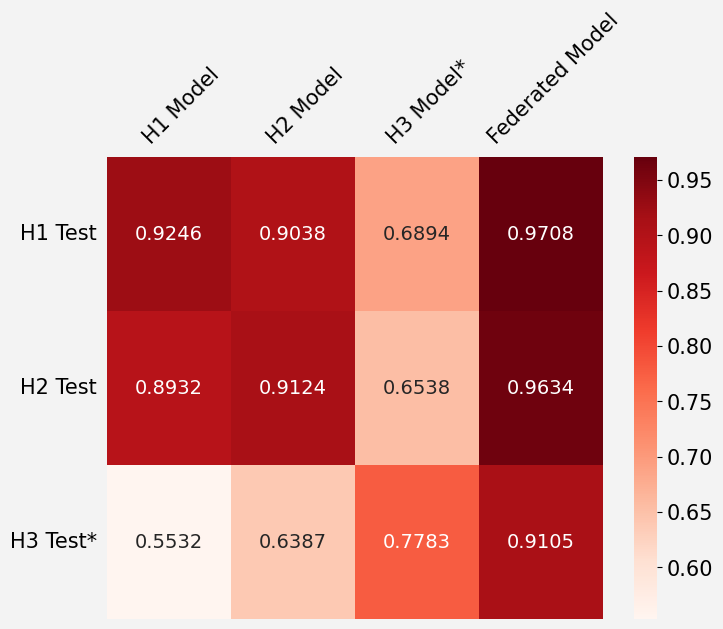

'\n\nimport matplotlib.pyplot as plt\nimport seaborn as sn\nimport numpy as np\n\n# Sample accuracy and standard deviation data (replace with your actual scores)\naccuracy_data = np.array([\n    [0.9246, 0.9038, 0.6894, 0.9708],\n    [0.8932, 0.9124, 0.6538, 0.9634],\n    [0.5532, 0.6387, 0.7783, 0.9105]\n])\n\nstd_dev_data = np.array([\n    [0.0123, 0.0256, 0.0874, 0.0098],\n    [0.0321, 0.0187, 0.1023, 0.0154],\n    [0.0785, 0.0932, 0.0543, 0.0215]\n])\n\n# Labels \nmodels = [\'H1 Model\', \'H2 Model\', \'H3 Model*\', "Federated Model"]\nmetrics = [\'H1 Test\', \'H2 Test\', \'H3 Test*\'] \n\n# Create the heatmap \nfig, ax = plt.subplots(figsize=(8, 6)) \nheatmap = sn.heatmap(accuracy_data, annot=True, fmt=\'.3f\', cmap=\'Reds\', \n           xticklabels=models, yticklabels=metrics, annot_kws={"size": 14}, cbar=False)\n\n# ... customization code from previous examples\n\n# Combine accuracy and std dev data into a single list of lists\ncombined_data = np.vstack((accuracy_data, std_dev_

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# Sample accuracy data (replace with your actual scores)
accuracy_data = [
    [0.9246, 0.9038, 0.6894, 0.9708],
    [0.8932, 0.9124, 0.6538, 0.9634],
    [0.5532, 0.6387, 0.7783, 0.9105]
]

# Labels
#plt.rcParams.update({'font.size':15})
models = ['H1 Model', 'H2 Model', 'H3 Model*', "Federated Model"]
metrics = ['H1 Test', 'H2 Test', 'H3 Test*']

# Create the heatmap
fig, ax = plt.subplots(figsize=(8,6))
sn.heatmap(accuracy_data, annot=True, fmt='.4f', cmap='Reds',
           xticklabels=models, yticklabels=metrics, annot_kws={"size": 14})


plt.yticks(rotation=0)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.xticks(rotation=45)

# Customization
xtick_pos = np.arange(len(models))  # Assuming xticklabels is your list of x-axis labels

# Adjust positions slightly to the right (e.g., +0.2)
adjusted_pos = xtick_pos + 0.6  # You can adjust the offset value as needed

# Set the new tick positions and labels
plt.xticks(adjusted_pos, models)

plt.tick_params(
    axis='both',       # Affects both x and y axes
    which='both',      # Affects both major and minor ticks
    bottom=False,      # Disable bottom ticks
    top=False,         # Disable top ticks (if you moved them to the top)
    left=False,        # Disable left ticks
    right=False        # Disable right ticks
)
fig.patch.set_facecolor('#F3F3F3')



plt.show()
"""

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# Sample accuracy and standard deviation data (replace with your actual scores)
accuracy_data = np.array([
    [0.9246, 0.9038, 0.6894, 0.9708],
    [0.8932, 0.9124, 0.6538, 0.9634],
    [0.5532, 0.6387, 0.7783, 0.9105]
])

std_dev_data = np.array([
    [0.0123, 0.0256, 0.0874, 0.0098],
    [0.0321, 0.0187, 0.1023, 0.0154],
    [0.0785, 0.0932, 0.0543, 0.0215]
])

# Labels
models = ['H1 Model', 'H2 Model', 'H3 Model*', "Federated Model"]
metrics = ['H1 Test', 'H2 Test', 'H3 Test*']

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sn.heatmap(accuracy_data, annot=True, fmt='.3f', cmap='Reds',
           xticklabels=models, yticklabels=metrics, annot_kws={"size": 14}, cbar=False)

# ... customization code from previous examples

# Combine accuracy and std dev data into a single list of lists
combined_data = np.vstack((accuracy_data, std_dev_data)).T  # Concatenate vertically, then transpose

def custom_annotate(ax, row, col, value, fmt="%.3f"):


    # Get the text position based on row and column indices
    x = col + 0.5
    y = row + 1.05  # Adjust y-offset for positioning below accuracy value

    # Format the text (accuracy on top, std dev below)
    text = f"{value[0]:{fmt}}\n(±{value[1]:.3f})"

    # Add annotation with reduced font size for std dev
    ax.text(x, y, text, ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))

# Apply custom annotation using fmt='.3f' for 3 decimal places
sn.heatmap(combined_data, annot=custom_annotate, fmt='.3f', cmap='Reds',
           xticklabels=models, yticklabels=metrics, annot_kws={"size": 14},
           cbar=False)  # Pass the custom annotation function

plt.show()
"""

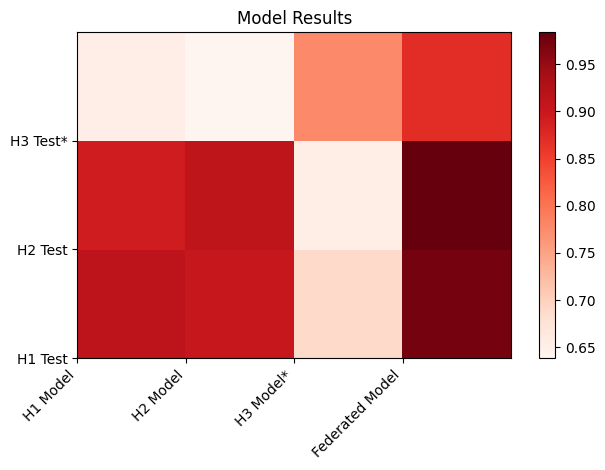

In [ ]:
# Create some data (you can replace this with your data)
data = [[0.9146, 0.9038, 0.6894, 0.9734],
        [0.8932, 0.9124, 0.6538, 0.9839],
        [0.6532, 0.6387, 0.7783, 0.8709]
]


row_labels = ["H1 Test", "H2 Test", "H3 Test*"]
col_labels = ["H1 Model", "H2 Model", "H3 Model*", "Federated Model"]

# Create a new figure for the plot
fig, ax = plt.subplots()

# Create a heatmap from the data
heatmap = ax.pcolor(data, cmap="Reds")  # You can choose a different colormap here

# Add labels and title
fig.colorbar(heatmap)  # Add a colorbar to show the color scale
ax.set_xticks(np.arange(len(col_labels)))  # Set the x-tick positions
ax.set_yticks(np.arange(len(row_labels)))  # Set the y-tick positions
ax.set_xticklabels(col_labels, rotation=45, ha="right")  # Set the x-tick labels
ax.set_yticklabels(row_labels)  # Set the y-tick labels
ax.set_title("Model Results")  # Set the title for the plot

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    print(new_dict)
    classes=list(new_dict.values())
    print(classes)     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')

    y_true= np.array(labels)

    y_pred=np.array(y_pred)









    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        new_orders = [2, 0, 1, 4, 3]
        print(new_orders)
        reordered_cm = cm[new_orders][:, new_orders]

        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(reordered_cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        #plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        #plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=90)
        plt.yticks(np.arange(length) + 0.5, [classes[i] for i in new_orders], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()





    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

    cm = confusion_matrix(y_true, y_pred)

    total = np.sum(cm, axis=1)
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = total - true_positives

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_positives / (true_positives + false_positives)

    sensitivity_dict = {classes[i]: sensitivity[i] for i in range(len(classes))}
    specificity_dict = {classes[i]: specificity[i] for i in range(len(classes))}

    print(sensitivity_dict, specificity_dict)







In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Example classifier
import matplotlib.pyplot as plt

In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

print("\nLogistic Regression")



Logistic Regression


{0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3: 'Proliferate_DR', 4: 'Severe'}
['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
[2, 0, 1, 4, 3]


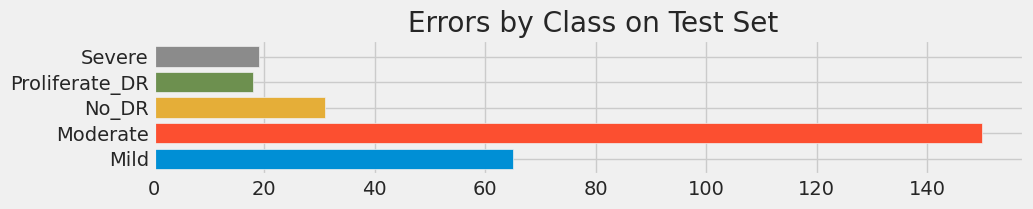

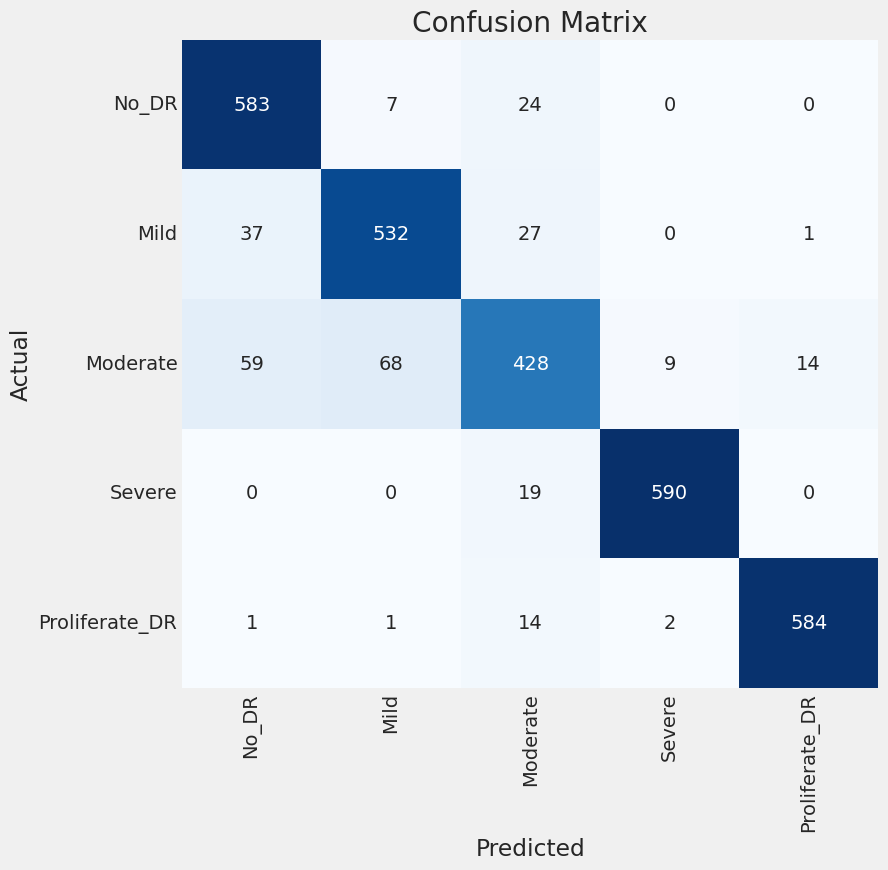

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.88      0.89      0.88       597
      Moderate       0.84      0.74      0.79       578
         No_DR       0.86      0.95      0.90       614
Proliferate_DR       0.97      0.97      0.97       602
        Severe       0.98      0.97      0.98       609

      accuracy                           0.91      3000
     macro avg       0.90      0.90      0.90      3000
  weighted avg       0.91      0.91      0.90      3000

{'Mild': 0.8911222780569514, 'Moderate': 0.740484429065744, 'No_DR': 0.9495114006514658, 'Proliferate_DR': 0.9700996677740864, 'Severe': 0.9688013136288999} {'Mild': 0.875, 'Moderate': 0.8359375, 'No_DR': 0.8573529411764705, 'Proliferate_DR': 0.9749582637729549, 'Severe': 0.9816971713810316}


In [ ]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, kaggle, print_code, save_dir, subject )

In [ ]:
from tensorflow.keras.models import save_model

efficientnetb0.save('my_efficientnetb0_model.keras')

In [ ]:
!pip install tensorflow numpy pillow matplotlib requests

In [ ]:
import PIL
import numpy as np
import requests

def get_processed_img(url):
    # Open the image using the URL
    img_from_url = PIL.Image.open(requests.get(url, stream=True).raw)

    # Adjust the image dimensions to a standard size.
    new_image = img_from_url.resize((224, 224))

    # Transform the image into a NumPy array.
    processed_image = np.asarray(new_image)

    # Normalise pixel values if necessary
    if processed_image.max() > 1:
        processed_image = processed_image / 255

    # Add a batch dimension
    image = np.expand_dims(processed_image, axis=0)

    return image

In [ ]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
visualize_gradcam(test_gen, grad_model, class_names=['No_DR, Mild, Moderate, Severe, Proliferative_DR'])

KeyboardInterrupt: 

In [ ]:
pred

array([[8.38798005e-03, 9.60496962e-01, 4.95462958e-03, 1.67155862e-02,
        9.44489986e-03],
       [1.94815057e-03, 9.94450331e-01, 5.23968716e-04, 1.07118406e-03,
        2.00644741e-03],
       [6.69874549e-02, 1.50360569e-01, 4.65270355e-02, 6.85303807e-02,
        6.67594552e-01],
       ...,
       [1.96195743e-03, 1.01007847e-03, 9.95528400e-01, 7.41795870e-04,
        7.57725385e-04],
       [2.08437562e-01, 6.00693896e-02, 3.04281302e-02, 4.56999913e-02,
        6.55364931e-01],
       [6.68797875e-03, 6.89202733e-03, 8.45978130e-03, 1.47180725e-02,
        9.63242114e-01]], dtype=float32)

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

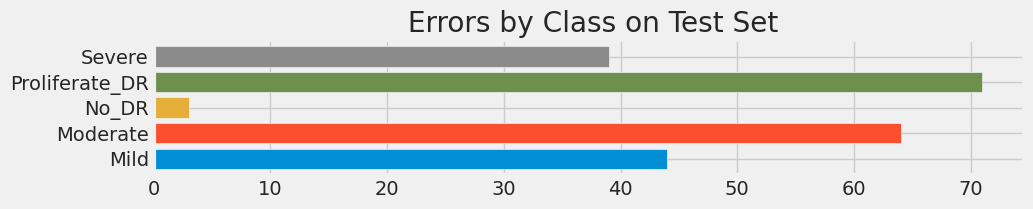

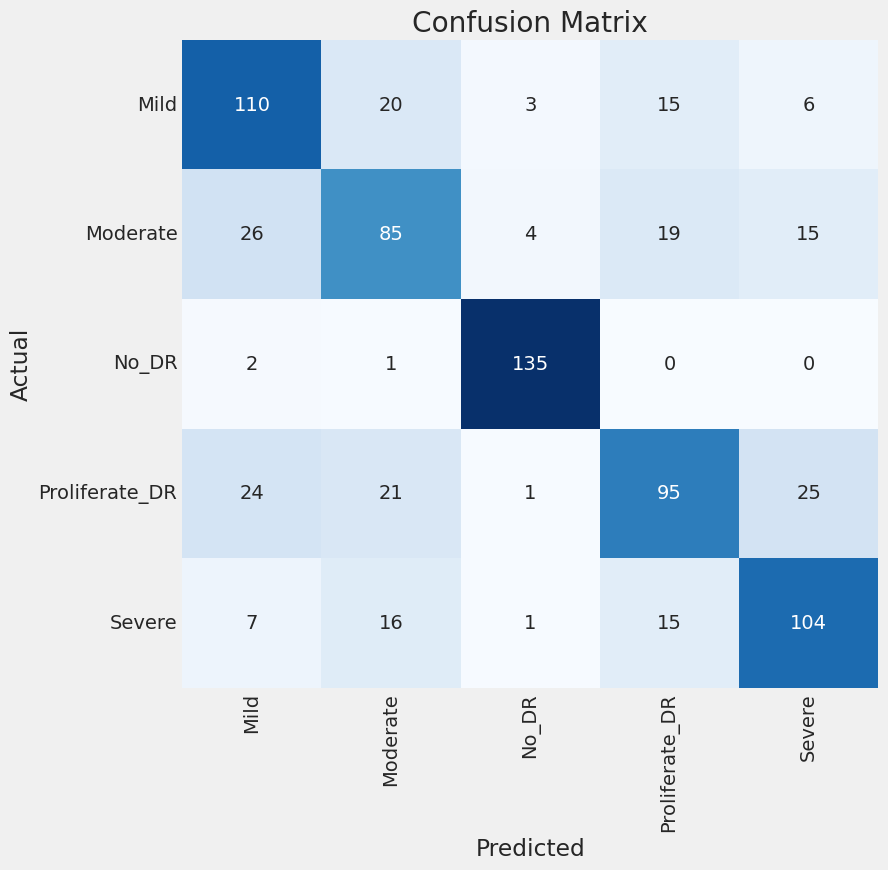

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.65      0.71      0.68       154
      Moderate       0.59      0.57      0.58       149
         No_DR       0.94      0.98      0.96       138
Proliferate_DR       0.66      0.57      0.61       166
        Severe       0.69      0.73      0.71       143

      accuracy                           0.71       750
     macro avg       0.71      0.71      0.71       750
  weighted avg       0.70      0.71      0.70       750



In [ ]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, mobilenetv2pred, print_code, save_dir, subject )


In [ ]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
efficientnetb1=Model(inputs=base_model.input, outputs=output)
efficientnetb1.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnetb1.summary()

27018416/27018416 [==============================] - 1s 0us/step
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_24 (Rescaling)    (None, 224, 224, 3)          0         ['input_18[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, 224, 224, 3)          7         ['rescaling_24[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_25 (Rescaling) 

In [ ]:
class LRA2(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0

    def __init__(self, model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA2, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model= model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch=initial_epoch
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (244, 252, 3), (55,65,80))
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
    def on_train_end(self, logs=None):
        model.set_weights(LRA2[0].best_weights())
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count


    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA2.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA2.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA2.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA2.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans



In [ ]:
epochs = 5
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks_efficientnetb1=[LRA(model=efficientnetb7,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_efficientnetb1=efficientnetb1.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks_efficientnetb7,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /5      7.270   53.339   5.96561  59.043   0.00100  0.00100  accuracy   110.94 

 2 /5      4.889   65.814   4.15972  67.287   0.00100  0.00100  accuracy   69.39  

 3 /5      3.517   71.711   3.01695  69.947   0.00100  0.00100  accuracy   69.43  

 4 /5      2.529   75.880   2.20828  73.404   0.00100  0.00100  accuracy   69.48  

 5 /5      1.809   81.146   1.69930  76.330   0.00100  0.00100  accuracy   69.52  



ValueError: You called `set_weights(weights)` on layer "model_6" with a weight list of length 448, but the layer was expecting 320 weights. Provided weights: [array([0.485, 0.456, 0.406], dtype=float32), arra...